## 0. Basic Packages

In [1]:
import pandas as pd
#Set copy warning to off
pd.set_option('mode.chained_assignment', None)
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

##### We import all the functions used in the previous notebooks

In [2]:
from nlp_preprocess import *
from nlp_clustering import *

/home/diego/anaconda3/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning:

CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)



##### We add accents to stop_words and exclude the words we want

In [3]:
from nltk.corpus import stopwords

#we select the spanish stop words (by default all the words with accents have them)
stop_words = stopwords.words('spanish')

#now we have the words with accents and the same ones without accents
stop_words = add_non_accents(stop_words)

#list to exclude in stop_words (excluded based in "count_stop_words" fn)
stop_w_list = ["no", "mucho", "muchos", "tiene", "tienen", "otras", "sin", "nada", "algo"
               "tanto", "alguna", "estamos", "tengan", "tenemos", "nuestros", "fuera", "algunos", "hasta"]

#exclude previous list of words from stop_words
stop_words.difference_update(stop_w_list)

#to latter set as env var
STOP_W_LIST = stop_w_list

## 1. Data Wrangling

In [4]:
f1 = pd.read_excel("comments.xlsx", [0])[0]
f2 = pd.read_excel("comments.xlsx", [1])[1]

df = pd.concat([f1, f2]) 
df.rename(columns={"Initial Classification":"Initial_Classification"}, inplace=True)
print(df.shape)
df.head()

(584, 4)


ID    Area                                            Comment  \
0   1  Dept 1  Cerrar la brecha entre los que deciden el trab...   
1   3  Dept 1  Sobretodo, que se miren las cargas de trabajo ...   
2   4  Dept 1  1. Dar coaching a algunos Gerentes (que no sab...   
3  19  Dept 1                                                  s   
4  29  Dept 1  Mas oportunidades de crecimiento y major salar...   

  Initial_Classification  
0               Negativo  
1               Negativo  
2               Negativo  
3               Negativo  
4               Negativo

### Checking for nulls

In [5]:
#cecking for nulls
df.isna().sum()

ID                         0
Area                       0
Comment                   11
Initial_Classification     0
dtype: int64

In [6]:
#checking data type
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 584 entries, 0 to 291
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ID                      584 non-null    int64 
 1   Area                    584 non-null    object
 2   Comment                 573 non-null    object
 3   Initial_Classification  584 non-null    object
dtypes: int64(1), object(3)
memory usage: 22.8+ KB


In [7]:
#cheking the null comments
df[df.Comment.isna()]

ID     Area Comment Initial_Classification
12    120   Dept 1     NaN               Negativo
48    561   Dept 4     NaN               Negativo
109  1280   Dept 7     NaN               Negativo
129  1475   Dept 9     NaN               Negativo
158  1768   Dept 9     NaN               Negativo
227  2481   Dept 9     NaN               Negativo
240  2587   Dept 9     NaN               Negativo
274  2850  Dept 10     NaN               Negativo
277  2887  Dept 10     NaN               Negativo
227  2481   Dept 9     NaN               Positivo
277  2887  Dept 10     NaN               Positivo

### Updating nulls with NA

In [8]:
#we will replace with the term "NA"
df.Comment[df.Comment.isna()] = "NA"

### Lowering comments

In [9]:
df.Comment = df.Comment.str.lower()

## 2. Preprocess

### Detecting language

In [10]:
#we create a new column with the detected lang
#choose between langdetect or cld3. By default cld3, which works bettter (for es)
df["language"] = dect_lang(df.Comment, detector="langdetect")

In [11]:
#we check the non-snpanish ones
for c, l in zip(df.Comment[df.language!="es"], df.language[df.language!="es"]):
    print("Sentence:", c, "---->", "Lang:", l)

Sentence: s ----> Lang: sv
Sentence: prefiero no comentar ----> Lang: it
Sentence: na ----> Lang: tl
Sentence: more alignment in priorities to focus more and accomplish better results. we try to do too much at the same time, limiting the chances of success.  ----> Lang: en
Sentence: reduce legal and compliance bureaucracy. there is a pervasive view that lawyers and risk managers can manage the business from afar. client facing employees are handcuffed and more worrisome, at times prefer not to look for better alternatives for clients afraid that they might run afoul of one of the many new rules. also, innovation is stifled by all the roadblocks and permissions needed to launch a product or service.  ----> Lang: en
Sentence: no cambiaria nada. ----> Lang: pt
Sentence: ninguna. ----> Lang: tl
Sentence: los salarios justos  ----> Lang: lt
Sentence: nada ----> Lang: so
Sentence: mejorar la paga ----> Lang: id
Sentence: na ----> Lang: tl
Sentence: no cambiaria nada. ----> Lang: pt
Sentence:

Once we have checked the previous output we can see the english comments are well identified, and the rest are either, errors / sentences with no meaning, or spanish sentences identified as catalan, italian or other language

Therefore it is fair to consider, non-english comments as spanish comments in this case

In [12]:
#we replace non-english comments for "es" term
df.language[df.language!="en"] = "es"

In [13]:
#we re-check the list again
for c, l in zip(df.Comment[df.language!="es"], df.language[df.language!="es"]):
    print("Sentence:", c, "---->", "Lang:", l)

Sentence: more alignment in priorities to focus more and accomplish better results. we try to do too much at the same time, limiting the chances of success.  ----> Lang: en
Sentence: reduce legal and compliance bureaucracy. there is a pervasive view that lawyers and risk managers can manage the business from afar. client facing employees are handcuffed and more worrisome, at times prefer not to look for better alternatives for clients afraid that they might run afoul of one of the many new rules. also, innovation is stifled by all the roadblocks and permissions needed to launch a product or service.  ----> Lang: en
Sentence: nothing specific ----> Lang: en
Sentence: some businesses within la empresa should be evaluated/treated differently than the rest of the company... because they are vey different in nature. employees / businesses should not be punished for situations that occurred more than 10 years ago under very different industry/market conditions.  ----> Lang: en
Sentence: most

### Creating Dataframe for each Language and clean df

In [14]:
df_es = df[df.language=="es"]
df_en = df[df.language=="en"]

In [15]:
df_initial = input("Please select 1 option among the following:\n - df_es\n - df_en\n")
print("\n")
while df_initial != "df_es" and df_initial != "df_en":
    df_initial = input("Please input one of the mentioned options\n")
    
if df_initial == "df_es":
    df_initial = df_es
    
else:
    df_initial = df_en

remove_accents = input("Select 'yes' to remove accents from your df, or 'no' to keep them\n")
while remove_accents != "yes" and remove_accents != "no":
    remove_accents = input("Please input 'yes' or 'no'\n")   
print("\n")

word_root = input("Select 'yes' if you want the root (lemma) of your word, input 'no' to keep the original word\n")
while word_root != "yes" and word_root != "no":
    word_root = input("Please input 'yes' or 'no'\n")   
print("\n")

stop_w = input("Select 'yes' if you want to include stop_words, else 'no'\n")
while stop_w != "yes" and stop_w != "no":
    stop_w = input("Please input 'yes' or 'no'\n")   
print("\n")


#making the variables env variables to use it in the next notebook
DF_INITIAL = df_initial
REMOVE_ACCENTS = remove_accents
WORD_ROOT = word_root
STOP_W = stop_w

Please select 1 option among the following:
 - df_es
 - df_en
df_es


Select 'yes' to remove accents from your df, or 'no' to keep them
yes


Select 'yes' if you want the root (lemma) of your word, input 'no' to keep the original word
no


Select 'yes' if you want to include stop_words, else 'no'
no




In [16]:
#function to clean comments of the dataset, dots, commas, accents, etc
#turn 'remove_accents' to 'no' if you want to keep words with accents (not recommended)
df_clean = clean_df(df_initial, remove_accents=remove_accents)

#function to remove stop_words, make lemmatization and basic bigrams/trigrams
#turn 'root' to 'yes' if you want the lemma the of the word, 'stop_w' to 'yes' if you want to keep stop_words list
df_processed = preprocess_df(df_clean, root=word_root, stop_w=stop_w, stop_words=stop_words)

## 3. Vectorize

### Vectorize & make n-grams from comments

In [17]:
vectorizer = input("Select the vectorizer you want between CountVectorizer / TfidfVectorizer\n")
while vectorizer != "CountVectorizer" and vectorizer != "TfidfVectorizer":
    vectorizer = input("Please input 'CountVectorizer' or 'TfidfVectorizer'\n")   
print("\n")

ngrams = input("Select the range o ngrams you want\n(1, 1) for unigrams\n(2, 2) for bigrams and so on\nYou can also mix (1, 3), which will create from unigrams to trigrams\nPlease, write a comma between them, whithout parenthesis\nLike this: 1, 2\n")
n1, n2 = int(ngrams.split(",")[0]), int(ngrams.split(",")[1])

#making the variables env variables to use it in the next notebook
VECTORIZER = vectorizer
NGRAMS = ngrams

Select the vectorizer you want between CountVectorizer / TfidfVectorizer
TfidfVectorizer


Select the range o ngrams you want
(1, 1) for unigrams
(2, 2) for bigrams and so on
You can also mix (1, 3), which will create from unigrams to trigrams
Please, write a comma between them, whithout parenthesis
Like this: 1, 2
3,3


In [18]:
#function to make grams from comments using 'CountVectorizer' or 'TfidfVectorizer'

#choose between both vectorizers, choose a tuple of grams, turn 'remove_accents' to 'no' if you want 
#words with accents (not recommended), and 'stop_w' to 'yes' if you want to include stop_words
df_vectorized = vectorizer_df(vectorizer=vectorizer, ngrams_range=(n1, n2), df=df_processed, remove_accents=remove_accents, stop_w=stop_w, stop_words=stop_words)
df_vectorized.id = df_vectorized.id.astype(int)

#### Merged df

In [19]:
#point to merge both dataframes a keep tracking the new grams with the original comments
df_merged = pd.merge(df_vectorized, df_processed, how="left", on=["id", "comment_type"])
print(df_merged.shape)
df_merged.head()

(5038, 8)


feature    id comment_type     score     area  \
0        _an_tiene  1724     Positivo  0.252462   Dept 9   
1  _anos_seguridad  1740     Positivo  0.229416   Dept 9   
2    _años_empresa   583     Positivo  0.182574   Dept 4   
3   _años_operando  2853     Positivo  0.333333  Dept 10   
4   _años_servicio   758     Positivo  0.230152   Dept 5   

                                             comment  \
0  es una organizacion solida se ha mantenido en ...   
1  mis padres se conocieron en el institucion. hi...   
2  llevo alrededor de 12 años en la empresa y tod...   
3  solidez en el mercado. no esperaría que cierre...   
4  compañia sólida. se preocupan por la salud y b...   

                                       clean_comment language  
0  organizacion solida mantenido favor consumidor...       es  
1  padres conocieron institucion hicieron familia...       es  
2  llevo alrededor años empresa años evaluaciones...       es  
3  solidez mercado no esperaria cierre operacione...       es  
4  compañia solida preocupan salud bienestar empl...       es

In [20]:
#code to show how the process is being done
df_merged[df_merged.duplicated(subset=["feature"], keep=False)].sort_values(by=["feature", "id", "comment"]).head(15)

feature    id comment_type     score    area  \
210   analytics_development_program   428     Positivo  0.316757  Dept 4   
211   analytics_development_program   469     Negativo  0.146828  Dept 4   
438            balance_trabajo_vida  1093     Negativo  0.200960  Dept 7   
439            balance_trabajo_vida  1321     Negativo  0.170086  Dept 8   
440           balance_vida_personal   421     Positivo  0.465730  Dept 4   
441           balance_vida_personal   899     Negativo  0.139800  Dept 5   
442           balance_vida_personal  1345     Negativo  0.345592  Dept 8   
443            balance_vida_trabajo   143     Negativo  0.188519  Dept 1   
444            balance_vida_trabajo   195     Negativo  0.241698  Dept 1   
445            balance_vida_trabajo  1070     Negativo  0.049752  Dept 7   
446            balance_vida_trabajo  1321     Negativo  0.155770  Dept 8   
482  beneficios_estabilidad_laboral  1721     Positivo  0.683892  Dept 9   
483  beneficios_estabilidad_laboral  2642     Positivo  0.424387  Dept 9   
503          beneficios_plan_medico   540     Positivo  0.340737  Dept 4   
504          beneficios_plan_medico  1081     Positivo  0.683892  Dept 7   

                                               comment  \
210  oportunidades de desarrollo como lean academy,...   
211  reforzaria las areas de liderazgo estrategico,...   
438  mantendria la flexibilidad de trabajar remoto ...   
439  me encanta el lugar que trabajo, me gusta trab...   
440  balance entre vida personal y trabajo. buenos ...   
441  1) la distancia que existe entre gerentes/supe...   
442  salarios más competitivos (a nivel de mercado)...   
443  promover el balance vida/trabajo (mas alla de ...   
444  continuar fomentando el balance de vida y trab...   
445  compensación, redistribución de tareas, cambio...   
446  me encanta el lugar que trabajo, me gusta trab...   
482          * buenos beneficios * estabilidad laboral   
483  beneficios, estabilidad laboral que se lo da s...   
503  edificio es comodo y tiene buenos beneficios c...   
504                   beneficios (plan medico, profit)   

                                         clean_comment language  
210  oportunidades desarrollo lean academy project ...       es  
211  reforzaria areas liderazgo estrategico intelig...       es  
438  mantendria flexibilidad trabajar remoto opcion...       es  
439  encanta lugar trabajo gusta trabajar unidad no...       es  
440    balance vida personal trabajo buenos beneficios       es  
441  distancia existe empleados estilo gerencial ar...       es  
442  salarios competitivos nivel mercado mayor bala...       es  
443  promover balance alla mencionarlo concrete muc...       es  
444  continuar fomentando balance vida trabajo prog...       es  
445  compensacion redistribucion tareas cambio gene...       es  
446  encanta lugar trabajo gusta trabajar unidad no...       es  
482              buenos beneficios estabilidad laboral       es  
483  beneficios estabilidad laboral da posicionamie...       es  
503  edificio comodo tiene buenos beneficios plan_m...       es  
504                      beneficios plan_medico profit       es

### 4. Clustering

##### Multilingual models able to use directly from sentence_transformers

In [21]:
#'distiluse-base-multilingual-cased' is the model recommended for ES by sentence_transformes

st_models = ["distiluse-base-multilingual-cased", "distiluse-base-multilingual-cased-v2",
            "paraphrase-xlm-r-multilingual-v1", "stsb-xlm-r-multilingual", "quora-distilbert-multilingual",
            "distilbert-multilingual-nli-stsb-quora-ranking", "xlm-r-100langs-bert-base-nli-stsb-mean-tokens"]

##### Multilingual models pre-trained from transformers library (this is the way to use them)

In [22]:
hf_models = ["bert", "distilbert"]

##### Cluster function

Please select 1 options among the following:
 - df_ngrams
 - positive_ngrams
 - negative_ngrams
 - df_clean_comments
 - positive_clean_comments
 - negative_clean_comments
df_ngrams




Please select 1 library among the following:
 - sentence_transformers
 - hugging_face
sentence_transformers




Please select 1 model among the following:
 - distiluse-base-multilingual-cased
 - distiluse-base-multilingual-cased-v2
 - paraphrase-xlm-r-multilingual-v1
 - stsb-xlm-r-multilingual
 - quora-distilbert-multilingual
 - distilbert-multilingual-nli-stsb-quora-ranking
 - xlm-r-100langs-bert-base-nli-stsb-mean-tokens
distiluse-base-multilingual-cased-v2




Please select 1 clustering method among the following:
 -kmeans
 -hdbscan
Take into account that for kmeans you will give a number clusters, while with hdbscan they are automatically computed
kmeans







For clustering please select between the 'euclidean' or 'cosine' distance
Hint: cosine distance is preferred when texts have different length
euclidean
As you selected kMeans, choose to scale data with 'yes' or not scale with 'no':
hint: scale is recommended with gradient descent algos like lin/log reression or distance algos like kMeans, KNN or SVM
no
----------------------------------------------------------------------------------------------------------
Getting the Shilouette Score...


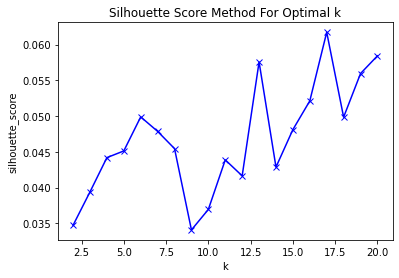

----------------------------------------------------------------------------------------------------------
Please write the number of clusters you want: 12
----------------------------------------------------------------------------------------------------------
Top 10 Explained Variance Variables by percentage
 [0.05349934 0.03708931 0.03184817 0.02831333 0.02349778 0.02245765
 0.0207945  0.01998818 0.01861409 0.01815396] 

Explained Variance by Percentage with the 3 components selected [0.05349939 0.03708924 0.0318481 ] 


----------------------------------------------------------------------------------------------------------
(4988, 5)
                         comments  clusters         x         y         z
0          acogedera_gente_calida        10 -3.360699 -2.488491 -6.137725
1       rotacion_lideres_gerentes         0 -0.007731 -6.027071 -2.235589
2      problemas_unidades_dejando         8 -1.832838 -0.464638  2.457088
3                hacen_salario_no         4 -3.836006  8

For wordcloud choose between 'unigrams' or 'computed'
computed
----------------------------------------------------------------------------------------------------------
Getting Wordcloud


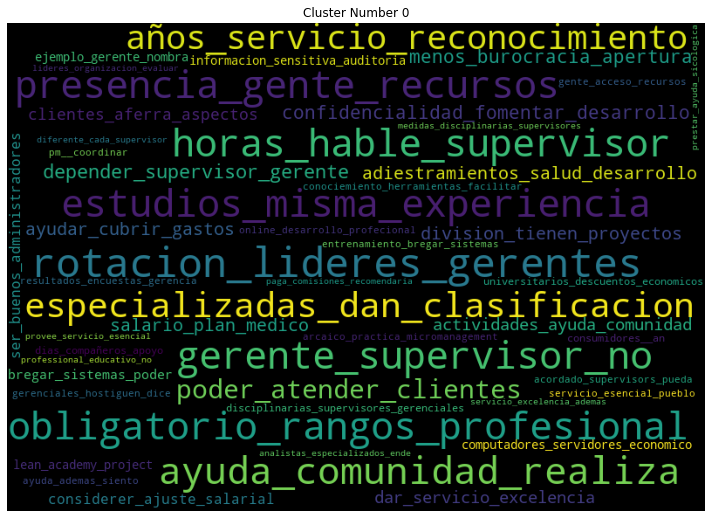

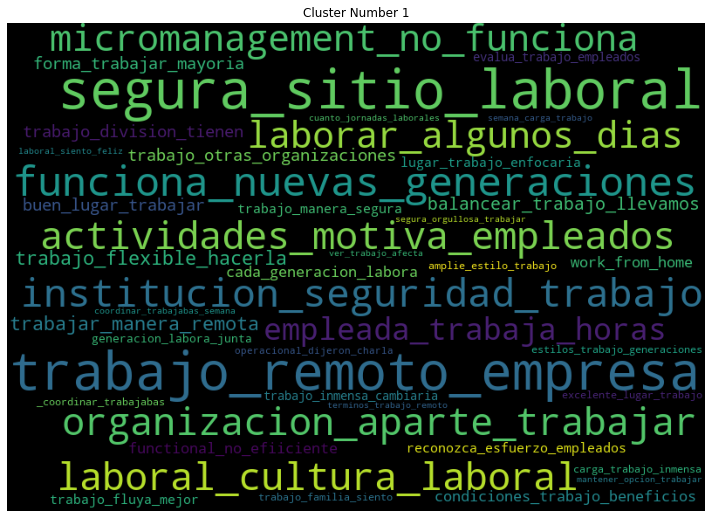

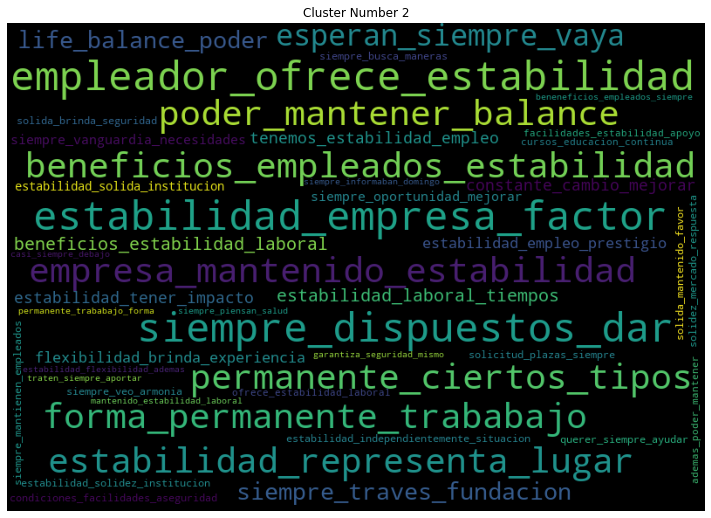

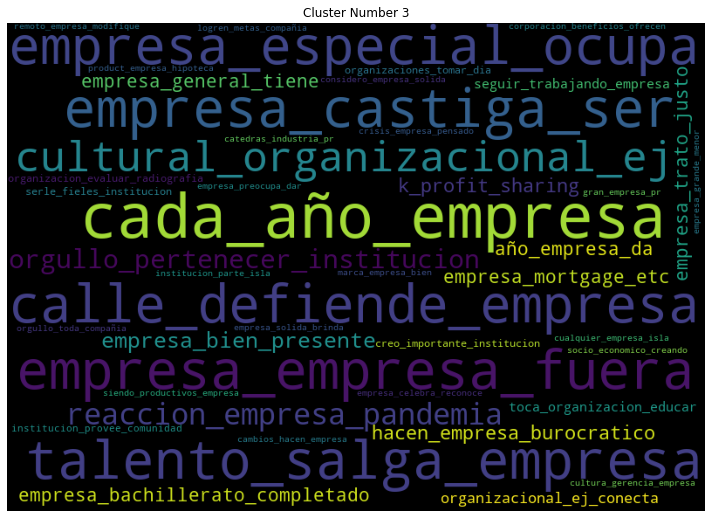

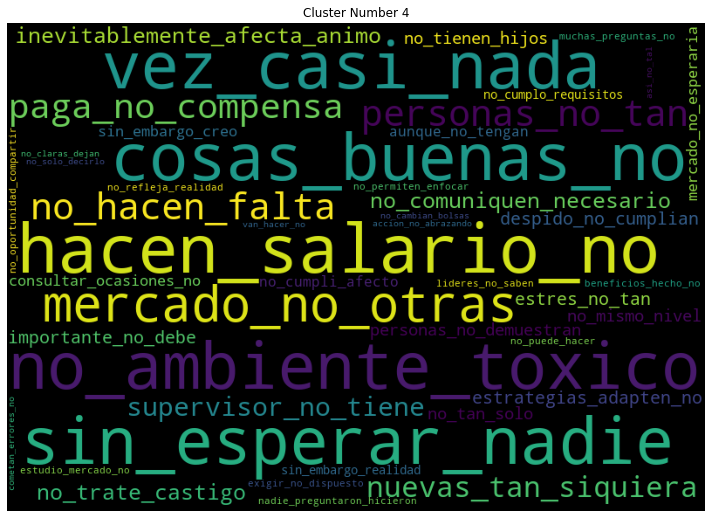

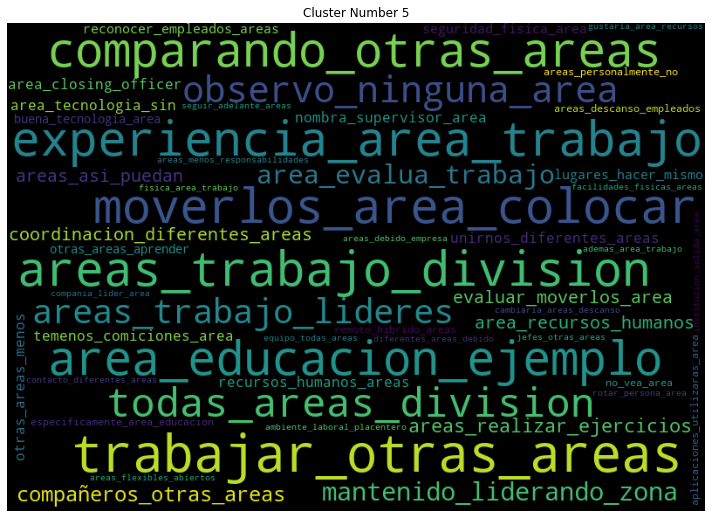

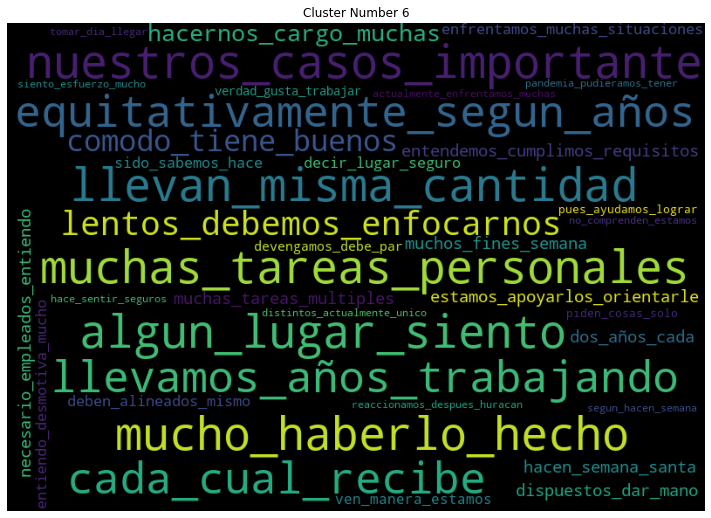

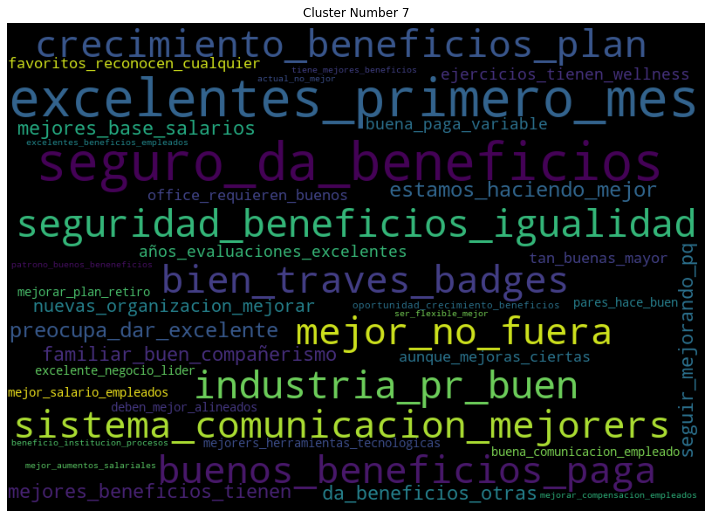

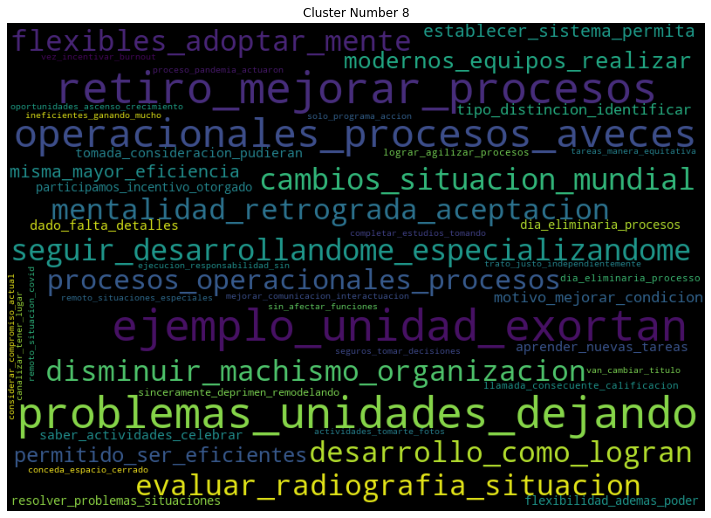

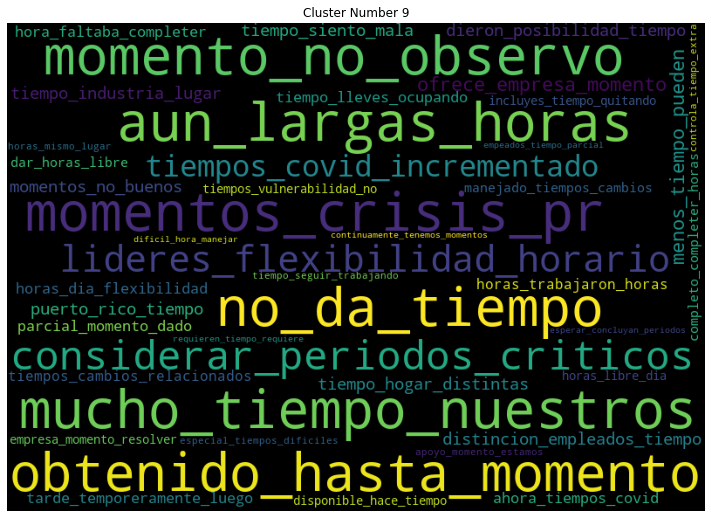

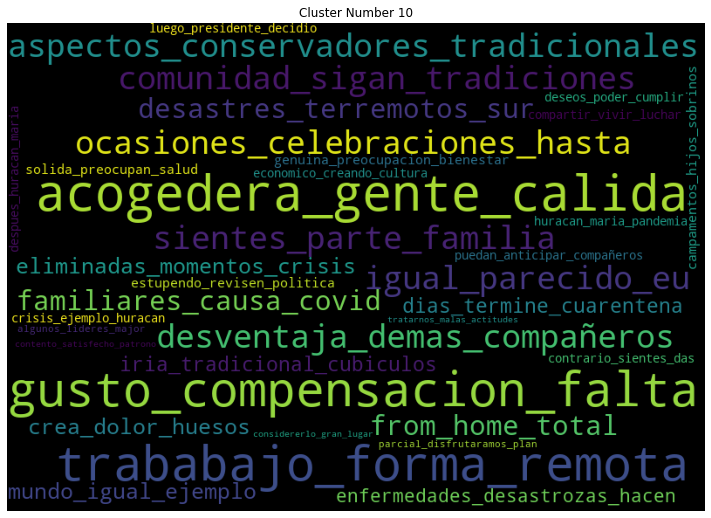

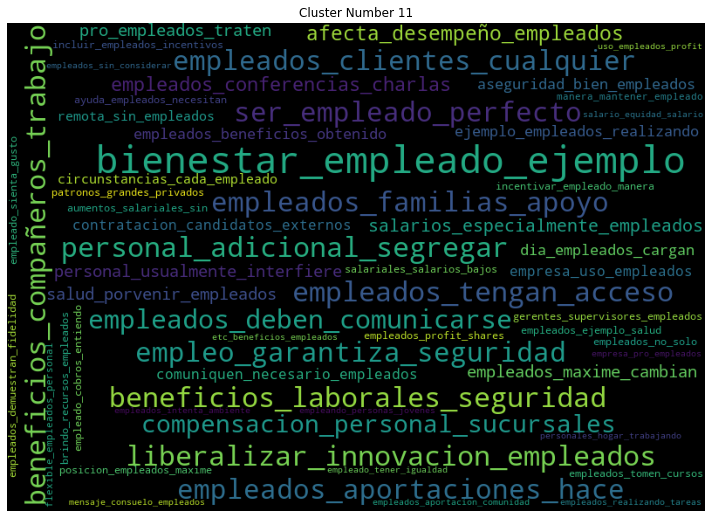

In [23]:
#function to cluster the comments and show them in a 3d graph and with a wordcloud per cluster

#select whole df (positive & negative), positive or negative comments
tokens = input("Please select 1 options among the following:\n - df_ngrams\n - positive_ngrams\n - negative_ngrams\n - df_clean_comments\n - positive_clean_comments\n - negative_clean_comments\n")
print("\n")
while tokens != "df_ngrams" and tokens != "positive_ngrams" and tokens != "negative_ngrams" and tokens != "df_clean_comments" and tokens != "positive_clean_comments" and tokens != "negative_clean_comments":
    tokens = input("Please input one of the mentioned options\n")   

df_tokens = tokens_selection(df_merged, element=tokens)
print("\n")

#choose 1 of the transformers libraries
transformers_pckg = input("Please select 1 library among the following:\n - sentence_transformers\n - hugging_face\n")
print("\n")
while transformers_pckg != "sentence_transformers" and transformers_pckg != "hugging_face":
    transformers_pckg = input("Please input one of the mentioned libraries\n")   
print("\n")

#choose 1 model if sentence_tranformers was chosed
if transformers_pckg == "sentence_transformers":
    model = input("Please select 1 model among the following:\n - distiluse-base-multilingual-cased\n - distiluse-base-multilingual-cased-v2\n - paraphrase-xlm-r-multilingual-v1\n - stsb-xlm-r-multilingual\n - quora-distilbert-multilingual\n - distilbert-multilingual-nli-stsb-quora-ranking\n - xlm-r-100langs-bert-base-nli-stsb-mean-tokens\n")
    print("\n")
    while model not in st_models:
        model = input("Please input one of the mentioned models\n")   
    print("\n")

#choose 1 model if hugging_face was chosed
elif transformers_pckg == "hugging_face":
    model = input("Please select 1 model among the following:\n - bert\n - distilbert\n")
    print("\n")
    while model not in hf_models:
        model = input("Please input one of the mentioned models\n")   
    print("\n")

#cluster method
cluster_method = input("Please select 1 clustering method among the following:\n -kmeans\n -hdbscan\nTake into account that for kmeans you will give a number clusters, while with hdbscan they are automatically computed\n")
print("\n")
while cluster_method != "kmeans" and cluster_method != "hdbscan":
    cluster_method = input("Please input one of the mentioned methods\n")   
print("\n")


#making the variables env variables to use it in the next notebook
TOKENS = tokens
TRANSFORMERS_PCKG = transformers_pckg
MODEL = model
CLUSTER_METHOD = cluster_method

#cluster df
if cluster_method == "kmeans":
    df_clusterized, cluster_distance, to_scale, kmeans_nclusters, wordcloud_ngrams = clusterize(model=model, cluster_method=cluster_method, comments=df_tokens)
    TO_SCALE = to_scale
    KMEANS_NCLUSTERS = kmeans_nclusters

else:
    df_clusterized, cluster_distance, hdbscan_csize, wordcloud_ngrams = clusterize(model=model, cluster_method=cluster_method, comments=df_tokens)
    HDBSCAN_CSIZE = hdbscan_csize


CLUSTER_DISTANCE = cluster_distance
WORDCLOUD_NGRAMS = wordcloud_ngrams

In [24]:
print(df_clusterized.shape)
df_clusterized.head()

(4988, 2)


comments  clusters
0          acogedera_gente_calida        10
1       rotacion_lideres_gerentes         0
2      problemas_unidades_dejando         8
3                hacen_salario_no         4
4  beneficios_laborales_seguridad        11

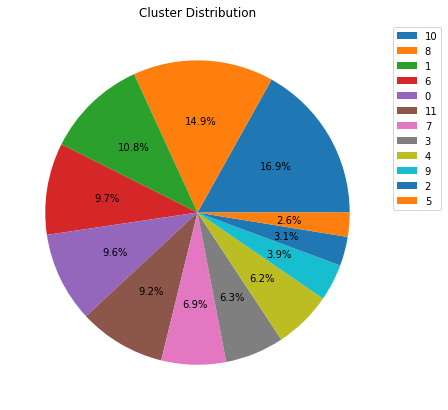

In [25]:
#frequency 'pie' or 'bar'
show_cluster_freq(df_clusterized, "pie")

## 5. Dendrogram

For clustering please select between the 'euclidean' or 'cosine' distance
Hint: cosine distance is preferred when texts have different length
cosine
Please write the number of words you want in the dendrogram:
The recommended number for a fair visualization is 20, 30 or 40, otherwise won't be shown
30
----------------------------------------------------------------------------------------------------------
Getting Dendrogram


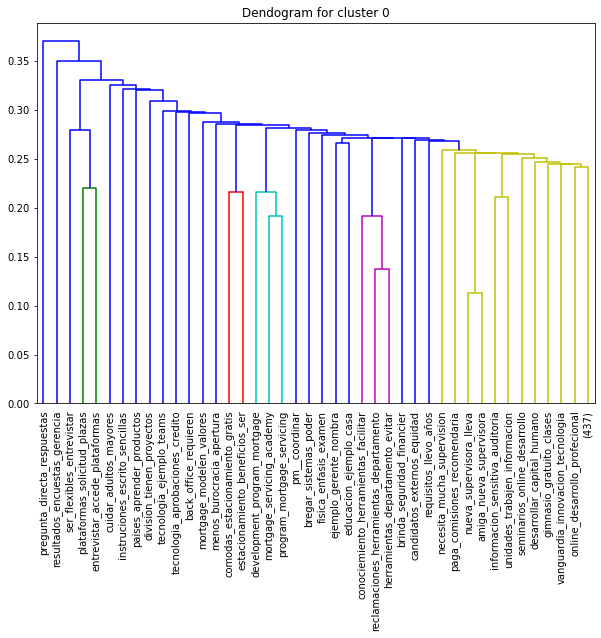

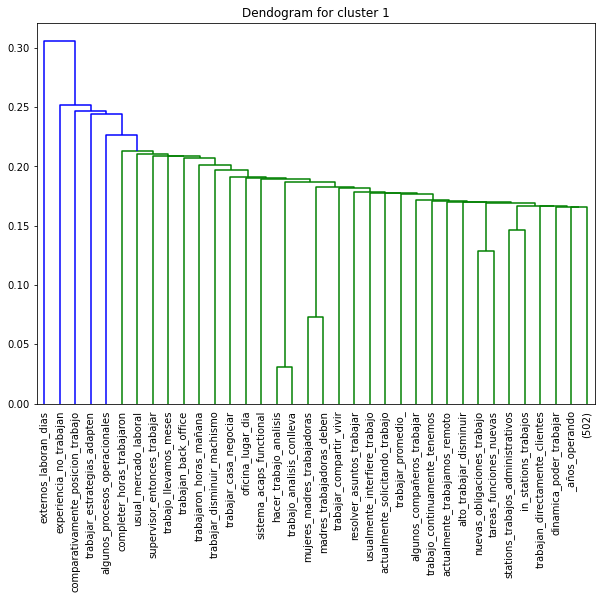

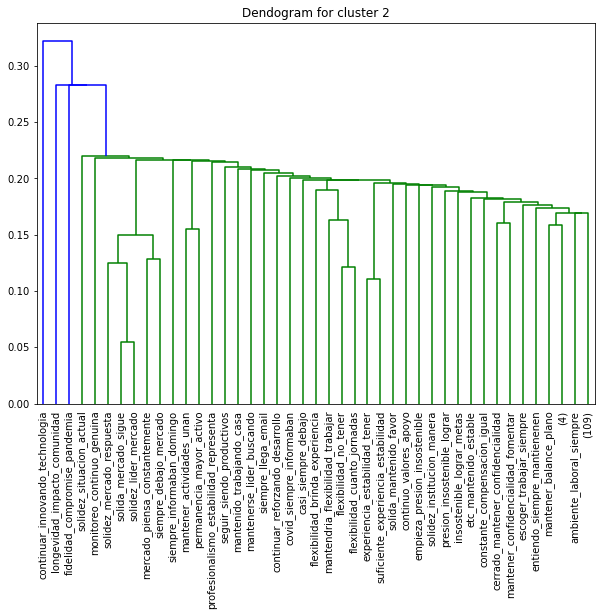

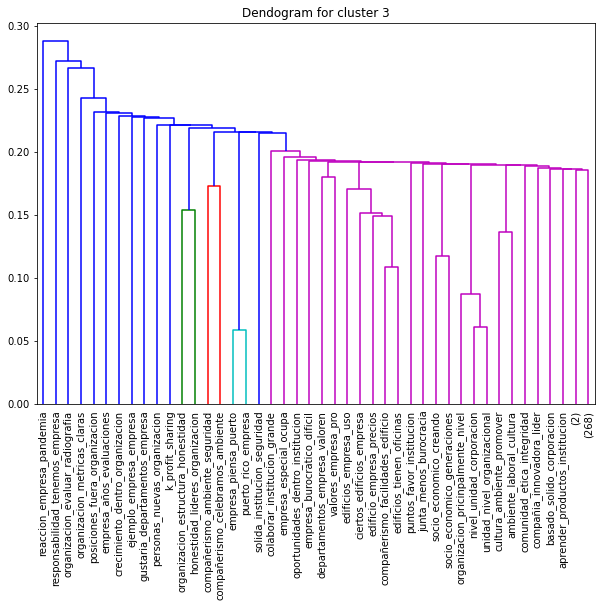

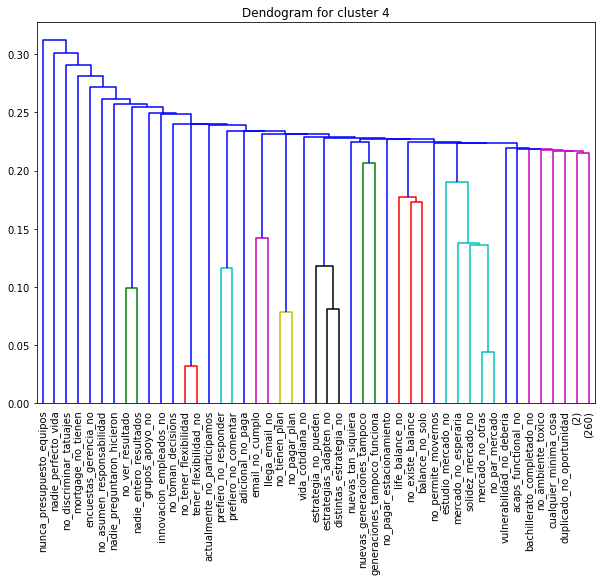

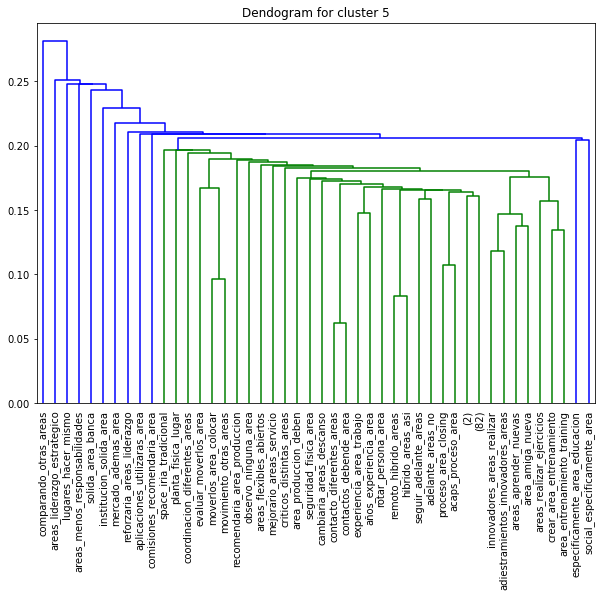

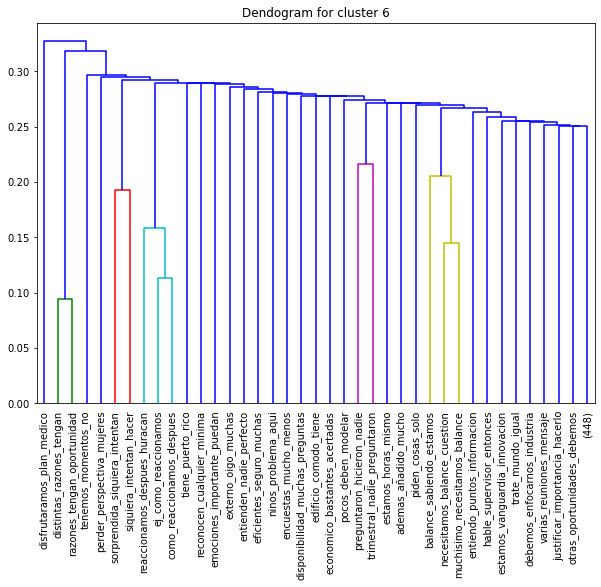

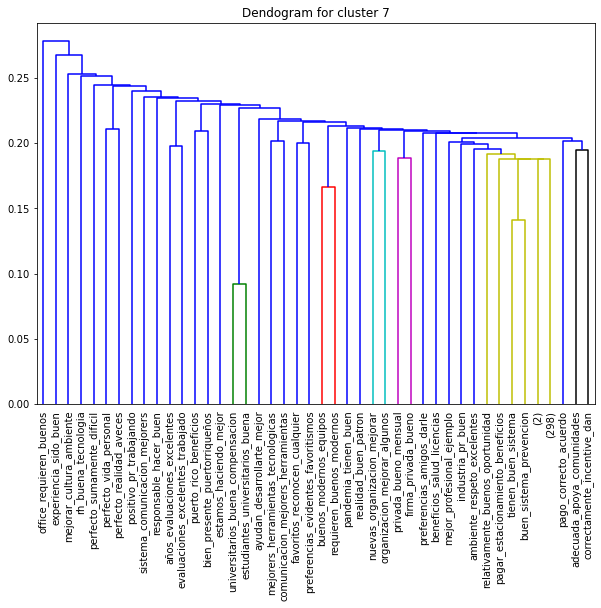

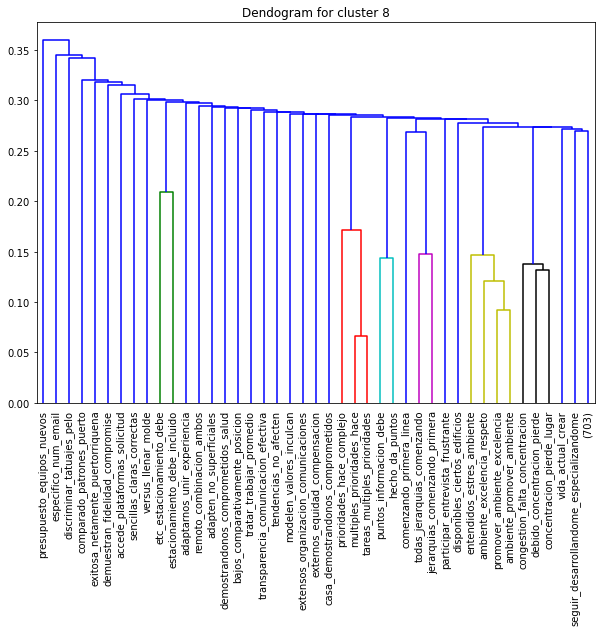

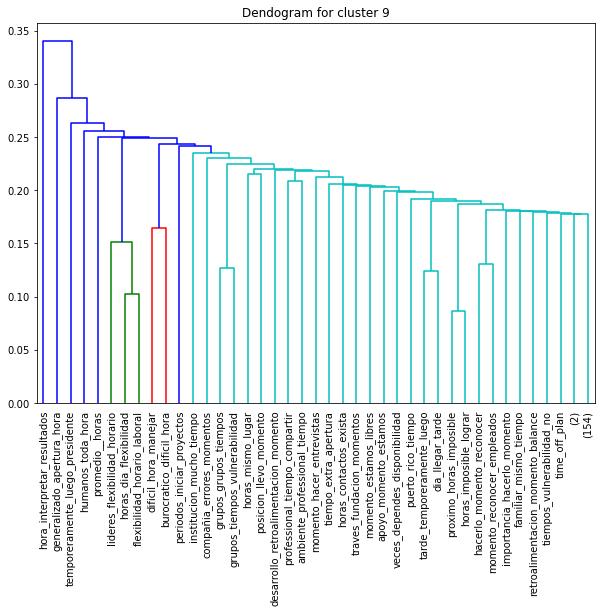

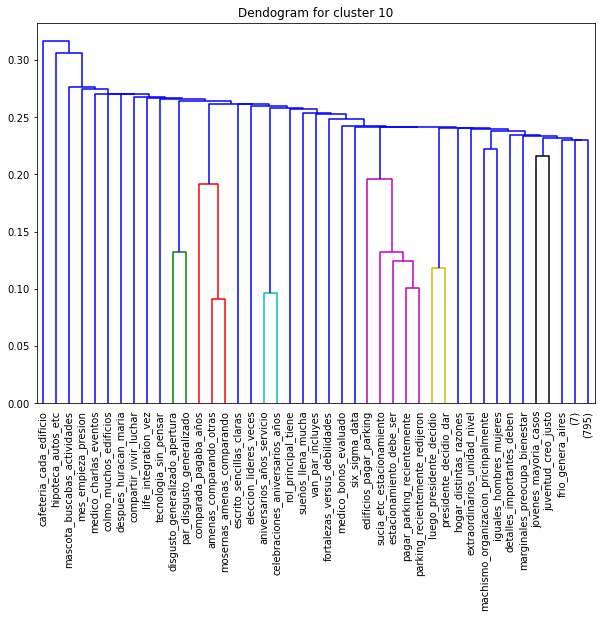

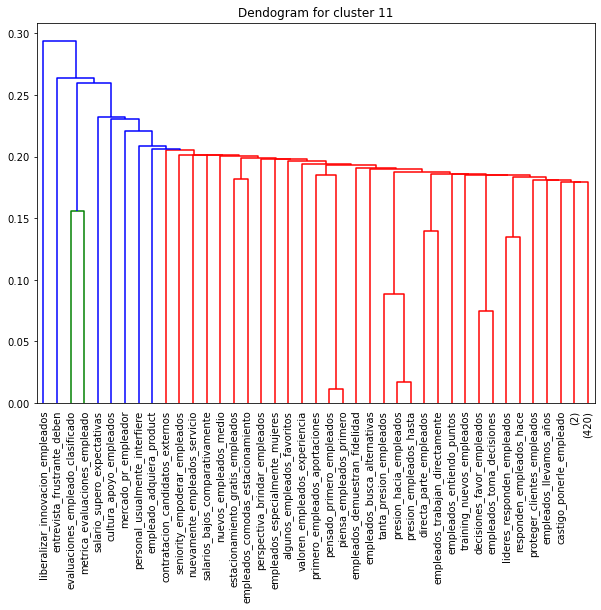

In [26]:
#this point will create a dendrogram for each cluster
d_metric = input("For clustering please select between the 'euclidean' or 'cosine' distance\nHint: cosine distance is preferred when texts have different length\n")
while d_metric != "euclidean" and d_metric != "cosine":
    d_metric = input("Please select 1 of the mentioned distances\n")

p = int(input("Please write the number of words you want in the dendrogram:\nThe recommended number for a fair visualization is 20, 30 or 40, otherwise won't be shown\n"))

print("----------------------------------------------------------------------------------------------------------")
print("Getting Dendrogram")

for i in list(set(df_clusterized.clusters)):
    comments = list(df_clusterized.comments[df_clusterized.clusters==i])
    
    if model in st_models:
        to_use_vecs = st_vectorize(comments=comments, model=model)
    
    elif model in hf_models:
        to_use_vecs = hf_vectorize(comments=comments, model=model)
        
    get_dendrogram(vecs=to_use_vecs, metric=d_metric, p=p, labels=comments, i=i)
    
    
#making the variables env variables to use it in the next notebook
DENDROGRAM_DISTANCE = d_metric
DENDROGRAM_P = p

## 6. Final Dataframe & Search Topic

In [27]:
df_final = final_df_selection(df1=df_merged, df2=df_clusterized, element=tokens)

print(df_final.shape)
df_final.head()

(5038, 9)


feature    id comment_type     score     area  \
0        _an_tiene  1724     Positivo  0.252462   Dept 9   
1  _anos_seguridad  1740     Positivo  0.229416   Dept 9   
2    _años_empresa   583     Positivo  0.182574   Dept 4   
3   _años_operando  2853     Positivo  0.333333  Dept 10   
4   _años_servicio   758     Positivo  0.230152   Dept 5   

                                             comment  \
0  es una organizacion solida se ha mantenido en ...   
1  mis padres se conocieron en el institucion. hi...   
2  llevo alrededor de 12 años en la empresa y tod...   
3  solidez en el mercado. no esperaría que cierre...   
4  compañia sólida. se preocupan por la salud y b...   

                                       clean_comment language  clusters  
0  organizacion solida mantenido favor consumidor...       es         4  
1  padres conocieron institucion hicieron familia...       es        10  
2  llevo alrededor años empresa años evaluaciones...       es         3  
3  solidez mercado no esperaria cierre operacione...       es         1  
4  compañia solida preocupan salud bienestar empl...       es         0

In [28]:
topics = list(*[t.split(", ") for t in [input("Please input a topic/s to search most similar comments in dataframe\nThe topics must be separated a comma and space\nEx 1 topic: informacion\nEx list of topics: informacion, comunicacion, lideres\n")]])
print("\n")


if model in st_models:
    vectorized_t = st_vectorize(comments=topics, model=model)
    
    if re.search("ngrams", tokens):
        vectors = st_vectorize(comments=list(df_final.feature), model=model)
    else:
        vectors = st_vectorize(comments=list(df_final.clean_comment), model=model)
        
elif model in hf_models:
    vectorized_t = hf_vectorize(comments=topics, model=model)
    
    if re.search("ngrams", tokens):
        vectors = hf_vectorize(comments=list(df_final.feature), model=model)
    else:
        vectors = hf_vectorize(comments=list(df_final.clean_comment), model=model)  
    
    
df_final["vectors"] = [v for v in vectors]

top_results = int(input("Please write the number of top comments per topic you want in the df:\n"))

columns = input("Please select between 'all' to return the whole dataframe or 'specific' to return id, area, comments and topic, both sort by similarity\n")
while columns != "all" and columns != "specific":
    columns = input("Please select 1 of the mentioned options\n")

dist = input("Please select between the 'euclidean' or 'cosine' distance\nHint: cosine distance is preferred when texts have different length\n")
while dist != "euclidean" and dist != "cosine":
    dist = input("Please select 1 of the mentioned distances\n")
    

df_topic = search_by_topic(df=df_final, top_results=top_results, columns=columns, dist=dist, vectors=vectorized_t, topics=topics)


#making the variables env variables to use it in the next notebook
SEARCH_TOPIC_COLUMNS = columns
SEARCH_TOPIC_DIST = dist

Please input a topic/s to search most similar comments in dataframe
The topics must be separated a comma and space
Ex 1 topic: informacion
Ex list of topics: informacion, comunicacion, lideres
informacion, comunicacion, lideres





Please write the number of top comments per topic you want in the df:
20
Please select between 'all' to return the whole dataframe or 'specific' to return id, area, comments and topic, both sort by similarity
specific
Please select between the 'euclidean' or 'cosine' distance
Hint: cosine distance is preferred when texts have different length
cosine


In [29]:
df_topic.head()

id    area                                            comment  \
2746  1081  Dept 7  mejorar la comunicacion, interactuacion de var...   
2761  1070  Dept 7  compensación, redistribución de tareas, cambio...   
2749  1472  Dept 9       buena comunicacion entre lideres y empleados   
2743   699  Dept 4  comunicacion de los gerentes hacia los empleados.   
2740  2200  Dept 9  que la comunicacion entre la gerencia intermed...   

             topic  
2746  comunicacion  
2761  comunicacion  
2749  comunicacion  
2743  comunicacion  
2740  comunicacion

In [30]:
df_topic.tail()

id    area                                            comment  \
13478  2574  Dept 9  actualmente la empresa mortgage ha implementad...   
7940    944  Dept 6  los mejores beneficios. tienen empatía, son so...   
7934   1477  Dept 9  si pudiera cambiar algo de mi unidad, seria la...   
13469  2342  Dept 9  cambiaria algunos supervisores y jefes de otra...   
13475  1025  Dept 6  cambiaria el que los supervisors y gerentes no...   

         topic  
13478  lideres  
7940   lideres  
7934   lideres  
13469  lideres  
13475  lideres

In [31]:
topic_name = ("_".join(topics)).replace(" ", "_")
df_topic.to_csv(f"df_topic_{topic_name}.csv", index=False)

##### Storing env variables to use in the other files

In [32]:
%store STOP_W_LIST
%store DF_INITIAL
%store REMOVE_ACCENTS
%store WORD_ROOT 
%store STOP_W 
%store VECTORIZER 
%store NGRAMS 

%store TOKENS 
%store TRANSFORMERS_PCKG 
%store MODEL 
%store CLUSTER_METHOD 

#cluster df
if cluster_method == "kmeans":
    %store TO_SCALE
    %store KMEANS_NCLUSTERS

else:
    %store HDBSCAN_CSIZE 


%store CLUSTER_DISTANCE 
%store WORDCLOUD_NGRAMS 

%store DENDROGRAM_DISTANCE
%store DENDROGRAM_P

%store SEARCH_TOPIC_COLUMNS
%store SEARCH_TOPIC_DIST 

Stored 'STOP_W_LIST' (list)
Stored 'DF_INITIAL' (DataFrame)
Stored 'REMOVE_ACCENTS' (str)
Stored 'WORD_ROOT' (str)
Stored 'STOP_W' (str)
Stored 'VECTORIZER' (str)
Stored 'NGRAMS' (str)
Stored 'TOKENS' (str)
Stored 'TRANSFORMERS_PCKG' (str)
Stored 'MODEL' (str)
Stored 'CLUSTER_METHOD' (str)
Stored 'TO_SCALE' (str)
Stored 'KMEANS_NCLUSTERS' (int)
Stored 'CLUSTER_DISTANCE' (str)
Stored 'WORDCLOUD_NGRAMS' (str)
Stored 'DENDROGRAM_DISTANCE' (str)
Stored 'DENDROGRAM_P' (int)
Stored 'SEARCH_TOPIC_COLUMNS' (str)
Stored 'SEARCH_TOPIC_DIST' (str)
